In [2]:
%pip install gitpython pandas tabulate
# %sudo apt-get install texlive-latex-base
# %sudo apt install pandoc
# %sudo apt-get install texlive-fonts-recommended
# %sudo apt-get install texlive-fonts-extra

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from git import Repo
import matplotlib.pyplot as plt
import pandas as pd

from helper_functions import plot_len_files, count_lines, count_complexity, get_py_files
from config import LANGCHAIN_FOLDER, LANGCHAIN_SUBFOLDER


In [4]:
repo = Repo(LANGCHAIN_FOLDER)

# visualize dependencies

In [61]:
from pathlib import Path
files = []
for file in Path(LANGCHAIN_FOLDER+LANGCHAIN_SUBFOLDER).rglob("*.py"):
    # ignore init files
    if "__init__" not in file.name:
        #print(file)
        files.append(file)
    
print(len(files))

3280


# Open every tag and print len(files)

In [62]:
TAGS_TO_ANALYZE = [
    "v0.0.1",
    "v0.0.100",
    "v0.0.200",
    "v0.0.300",
    "v0.1.0",
    "v0.1.4",
    "v0.1.8",
    "v0.1.12",
    "v0.1.16",
]   

In [63]:
d = {}
for tag in TAGS_TO_ANALYZE:
    repo.git.checkout(tag)
    d[tag] = {}
    d[tag]["datetime"] = repo.head.commit.committed_datetime
    d[tag]["py_files"] = get_py_files(LANGCHAIN_FOLDER+LANGCHAIN_SUBFOLDER)
    d[tag]["len_files"] = len(d[tag]["py_files"])

In [64]:

df = pd.DataFrame(d).T
df = df.sort_values("datetime")

/tmp/ipykernel_828/1539661477.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


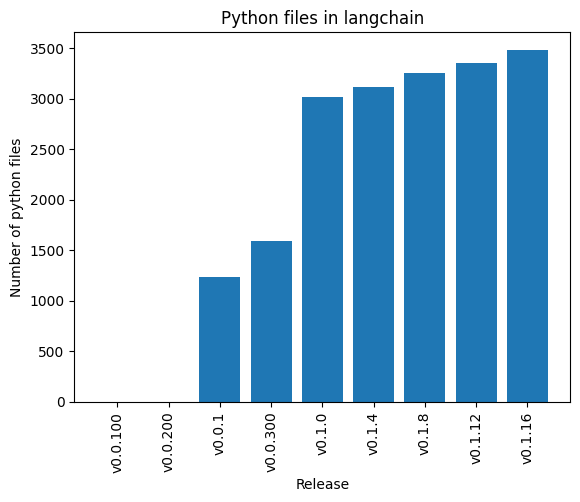

In [65]:
fig = plot_len_files(df)
plt.title("Python files in langchain")
plt.xlabel("Release")
plt.ylabel("Number of python files")
fig.show()
fig.savefig("../figs/len_files.png")

# Compute complexity and lines per file

In [53]:
TAGS_TO_ANALYZE_2 = [str(tag) for tag in repo.tags if "v0." in str(tag)]

In [54]:
d = {}
for tag in TAGS_TO_ANALYZE_2:
    repo.git.checkout(tag)
    d[tag] = {}
    commit_datetime = repo.head.commit.committed_datetime
    py_files = get_py_files(LANGCHAIN_FOLDER+LANGCHAIN_SUBFOLDER)
    for f_path in py_files:
        with open(f_path, "r") as f:
            try:
                f_str = f.read()
            except:
                print(f_path)
                pass
            d[tag][str(f_path)] = {}
            d[tag][str(f_path)]["lines"] = count_lines(f_str)
            d[tag][str(f_path)]["complexity"] = count_complexity(f_str, strategy="prefix_spaces")
            d[tag][str(f_path)]["tag"] = str(tag)
            d[tag][str(f_path)]["datetime"] = commit_datetime



langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/examples/non-utf8-encoding.py
langchain/libs/langchain/tests/integration_tests/exa

In [55]:
dfs = [pd.DataFrame(d[tag]).T for tag in d.keys()]
df = pd.concat(dfs)

In [56]:
complexity_subset_df = df.groupby("tag")[["lines", "complexity"]].mean()

In [60]:
complexity_subset_df[complexity_subset_df.index.isin(TAGS_TO_ANALYZE)]#.groupby("tag")["complexity"].mean()

,lines,complexity
tag,,
v0.0.1,126.095857,794.898457
v0.0.300,136.487713,890.550725
v0.1.0,104.861258,681.915563
v0.1.12,113.313731,750.885373
v0.1.16,116.82309,779.568352
v0.1.4,107.826547,707.113177
v0.1.8,110.650799,728.836609


### join datetime and sort

In [17]:
datetime_rows = df[["tag", "datetime"]].drop_duplicates()

In [18]:
datetime_rows.index = datetime_rows.tag
datetime_rows = datetime_rows.drop("tag", axis=1)

In [19]:
complexity_subset_df = complexity_subset_df.merge(
    datetime_rows,
    left_index=True,
    right_index = True
).sort_values("datetime")

In [20]:
filecount_subset_df = df.groupby("tag").count()
filecount_subset_df["no_files"] = filecount_subset_df["lines"]
complexity_subset_df = complexity_subset_df.merge(
    filecount_subset_df[["no_files"]],
    left_index=True,
    right_index = True
)


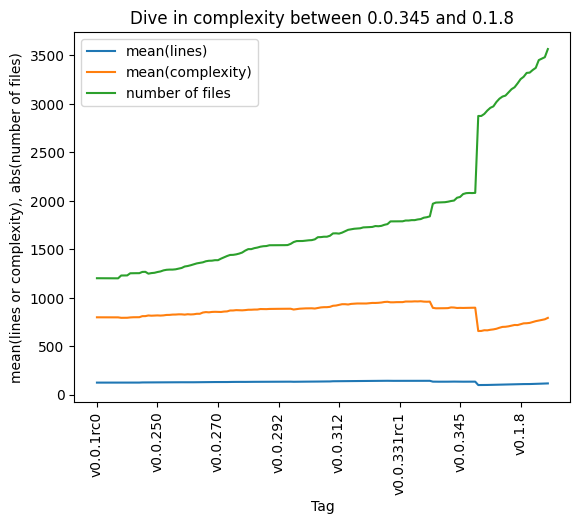

In [22]:
ax = complexity_subset_df.plot(y='lines', kind='line', label='mean(lines)', use_index=True)
complexity_subset_df.plot(y='complexity', kind='line', label='mean(complexity)', ax=ax, use_index=True)
complexity_subset_df.plot(y='no_files', kind='line', label='number of files', ax=ax, use_index=True)

plt.title('Dive in complexity between 0.0.345 and 0.1.8')
plt.xlabel('Tag')
plt.ylabel('mean(lines or complexity), abs(number of files)')
plt.xticks(rotation=90)
plt.legend()

plt.savefig("../figs/mean_lines_complexity.png")

plt.show()

In [24]:
complexity_subset_df["complexity_diff"] = complexity_subset_df["complexity"].diff()

In [26]:
iloc_highest_diff = complexity_subset_df["complexity_diff"].argmin()
commit_with_highest_diff = complexity_subset_df.iloc[iloc_highest_diff]

In [27]:
commit_with_highest_diff.name

'v0.0.349'

### Comparing v0.0.348 with v0.0.349

In [23]:
df_commits = df[df["tag"].isin(["v0.0.348", "v0.0.349"])]
df_348 = df[df["tag"].isin(["v0.0.348"])]
df_349 = df[df["tag"].isin(["v0.0.349"])]

In [24]:
print("% complexity after change =", (df_349.complexity.mean() / df_348.complexity.mean()) * 100)
print("%lines of after code change =", (df_349.lines.mean() / df_348.lines.mean()) * 100)


% complexity after change = 73.4465393862498
%lines of after code change = 74.61691465517687


### How have the files between the 2 commits changed?

In [27]:

# Specify the commit hashes you want to compare
commit_hash_old = 'e4d6e55'  # Replace with the older commit hash
commit_hash_new = '14bfc5f'  # Replace with the newer commit hash

# Get the commit objects from their hashes
commit_old = repo.commit(commit_hash_old)
commit_new = repo.commit(commit_hash_new)
diff_index = commit_old.diff(commit_new, create_patch=True)

In [28]:
l_diff_failed = []
d_diff = {}
for diff_item in diff_index:
    
    try:
        diff_data = diff_item.diff.decode("utf-8")  # Get the diff data as a string
    except:
        l_diff_failed.append(diff_item)
        pass
    
    added_lines = diff_data.count('\n+') - diff_data.count('\n++')
    removed_lines = diff_data.count('\n-') - diff_data.count('\n--')
    d_diff[diff_item.a_path] = {}
    d_diff[diff_item.a_path]["lines_added"] = added_lines
    d_diff[diff_item.a_path]["lines_removed"] = removed_lines
    d_diff[diff_item.a_path]["change_type"] = diff_item.change_type
    d_diff[diff_item.a_path]["diff_data"] = diff_data
    d_diff[diff_item.a_path]["renamed"] = diff_item.renamed
    d_diff[diff_item.a_path]["rename_from"] = diff_item.rename_from
    d_diff[diff_item.a_path]["rename_to"] = diff_item.rename_to
    

/tmp/ipykernel_828/3461250746.py:22: DeprecationWarning: Diff.renamed is deprecated, use Diff.renamed_file instead
  d_diff[diff_item.a_path]["renamed"] = diff_item.renamed


In [29]:
diff_index_no_patch = commit_old.diff(commit_new, create_patch=False)
for diff_item in diff_index_no_patch:
    if diff_item.a_path in d_diff:
        d_diff[diff_item.a_path]["change_type"] = diff_item.change_type
    

In [30]:
diff_df = pd.DataFrame(d_diff).T

In [33]:
md_table = diff_df.change_type.value_counts().to_markdown()
for row in md_table.split("\n"):
    print(row)

| change_type   |   count |
|:--------------|--------:|
| M             |     940 |
| R             |     523 |
| A             |      54 |
| D             |       5 |


# TODO: Get am overview of what changes were introduced

# TODO: Create a static analysis of dependencies, compare the graphs of 0.0.348 and 0.0.349

# TODO: Look for places to improve the existing code in the project (using graph approach or analyzing coupling based on files changed together)